---


<h1 style="text-align:center"> 
Lung Cancer Classification using CT Data (Smoke Detector)
</h1><style>

---

- Constança Fernandes, nº
- Daniela Osório, nº202208679
- Inês Amorim, nº2021108108
- Pedro Afonseca, nº202205394

---

## Introduction

> The integration of artificial intelligence (AI) into lung cancer screening represents a transformative approach to early detection and diagnosis, as lung cancer has a high mortality rate and many times it is diagnosed in the middle and late stages, when few therapies are available. The late diagnose happens beacause there are no obvious symptoms at an early stage **[2]**. With the ability to analyze complex medical data, AI enhances the identification of pulmonary nodules, ultimately improving patient outcomes. 

> Innovations such as low-dose computed tomography (LDCT) and computer-aided detection (CAD) systems enable precise characterization of nodules, facilitating personalized treatment strategies. As the field advances, ongoing research continues to explore the intersection of imaging techniques and AI, aiming to refine diagnostic processes and minimize the need for invasive procedures. **[1]**

--- 
## Libraries


In [1]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import get_malignancy_class, cluster_annots, get_cropped_annot
import pydicom
from radiomics import featureextractor
import SimpleITK as sitk
import os
import re
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, RocCurveDisplay, roc_auc_score, fbeta_score, balanced_accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from typing import Tuple
from collections import defaultdict

In [ ]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pylidc must be in lung-cancer-classification directory
print(pl.__file__)

/home/inesamorim46/3ano1sem/labiacd/proj_1/lung-cancer-classification/pylidc/__init__.py


---

## Importing XML files

In [3]:
nodule_counts_df = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')
nodule_counts_df.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


> We chose not to use the Excel file containing nodule counts because it lacks the important information necessary for our analysis. Specifically, the file does not provide essential details about the characteristics or context of the nodules, which are necessary for accurately assessing their implications for lung cancer diagnosis and treatment.

In [4]:
pacient_data_df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
pacient_data_df.head()

,TCIA Patient ID,"Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n",Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response,Primary tumor site for metastatic disease,"Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 3\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 3\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 4\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 4\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 5\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 5\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(pacient_data_df.shape)

(157, 14)


> We decided not to use the Excel file containing patient data from previous scans and cancers due to its limited scope, as it only includes information for about 10% of the patients studied. 

---


## Importing and Handling Annotations

> Although extracting features from CT Scans using Radiomics and Neural Networks provides information that is not yet seen by humans at first sight, most of the researchers don't believe these methods will replace the radiologists' role. Instead, using expert-reviwed data enhances the reliability of the features obtained, leading to better clinical outcomes **[3]**. Having this into account, it is still relevant to use the annotations features.


> As was done in **[4]**, the nodule annotations were used to obtain a consensus, where each feature is the average of the level assigned by each radiologist, rounded to the nearest integer. 


> The code used to obtain this dataset is written and explained  in **'process_anns.ipynb'**.

> To see the process done to obtain this dataframe, please see document **"process_anns.ipynb"**

In [6]:
df_annotations = pd.read_csv('annotations_ds.csv', index_col=0)
df_annotations 

,ID,Scan_ID,Patient_ID,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,Internal Structure,Subtlety,Malignancy
0,2,1,LIDC-IDRI-0078,5,2,2,3,4,6,1,4,4
1,1,1,LIDC-IDRI-0078,4,2,3,3,4,6,1,5,4
2,8,1,LIDC-IDRI-0078,5,1,1,5,5,5,1,4,1
3,3,1,LIDC-IDRI-0078,5,3,3,3,4,5,1,5,4
4,16,2,LIDC-IDRI-0069,5,4,4,4,4,6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2656,6850,1016,LIDC-IDRI-0639,3,3,2,2,4,6,1,4,4
2657,6851,1016,LIDC-IDRI-0639,1,2,1,2,4,6,1,2,4
2658,6856,1017,LIDC-IDRI-0638,5,1,2,4,4,6,1,3,4
2659,6855,1017,LIDC-IDRI-0638,5,1,1,5,4,6,1,5,2


---


###  Analysing Class Distribution from Data Extracted from Annotations

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

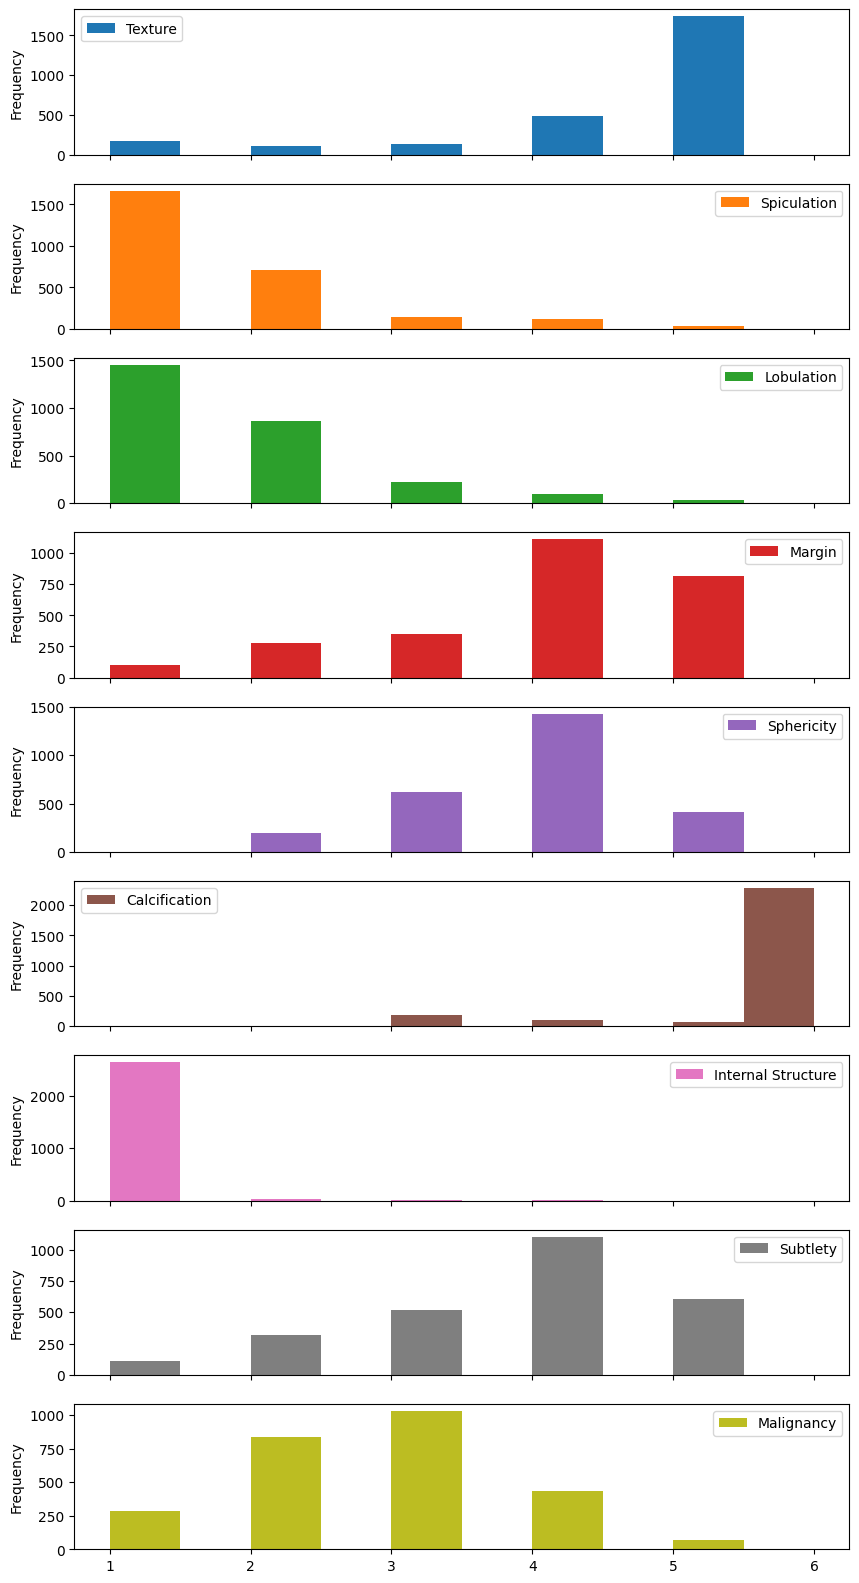

In [7]:
df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).plot(kind="hist", subplots=True, figsize=(10, 20))

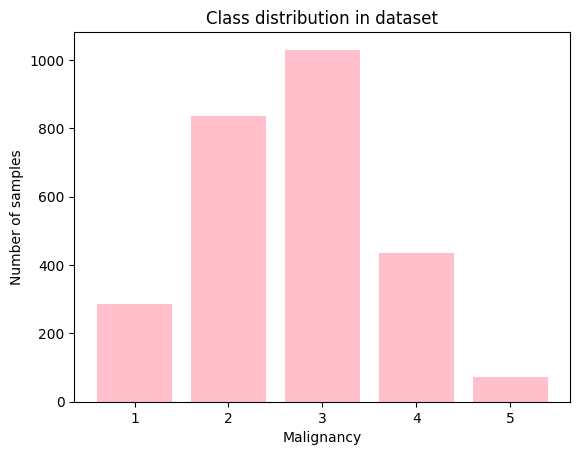

In [8]:
unique_labels, counts = np.unique(df_annotations["Malignancy"], return_counts=True)
plt.bar(unique_labels, counts, color='pink')
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

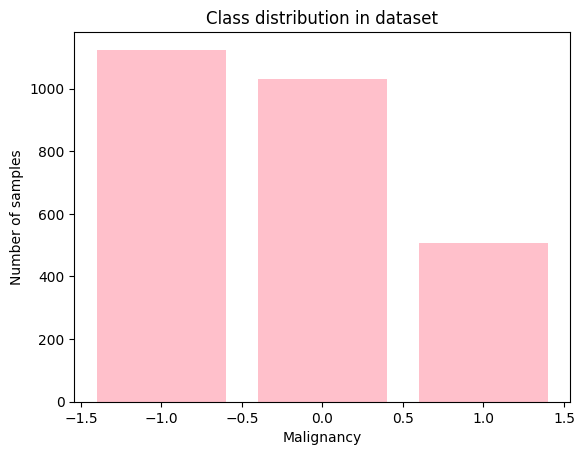

In [9]:
df_annotations["class"] = df_annotations["Malignancy"].apply(get_malignancy_class)

unique_labels, counts = np.unique(df_annotations["class"], return_counts=True)
plt.bar(unique_labels, counts, color='pink')
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

<Axes: >

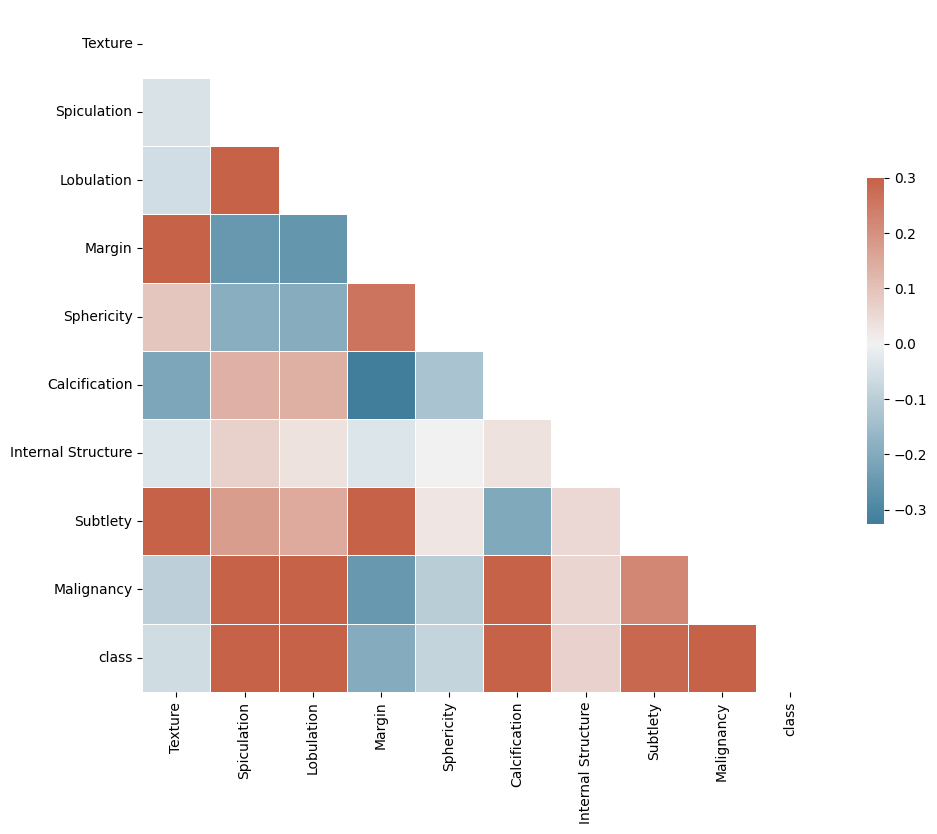

In [10]:
# Compute the correlation matrix
corr = df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

---

## Feature Extraction from CT Scans

These features describe various properties of the image, such as texture, shape, inetnsity, and spatial relationships, which may not be visible to the naked eye

### 1. Radiomics

> To see the process done to obtain the extracted features through *pyradiomics*, please see document **"process_radiomics.ipynb"**

In [13]:
df_radiomics = pd.read_csv('radiomics.csv')
df_radiomics

,Unnamed: 0,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Patient_ID,ID
0,0,0.823485,0.422484,3.597711,8.515614,8.062258,9.848858,10.049876,10.246951,139.958333,...,1.000000e+00,0.013514,5329.0,0.181343,1.392715,0.009703,0.000078,1.165431,LIDC-IDRI-0848,5523
1,1,0.822030,0.332701,5.249749,15.779186,19.026298,18.248288,15.000000,19.052559,747.750000,...,-3.203427e-16,0.001312,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0159,1338
2,2,0.737988,0.325554,2.055999,6.315384,5.099020,7.071068,7.071068,7.141428,39.541667,...,-3.203427e-16,0.022222,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0159,1339
3,3,0.594263,0.285487,14.952101,52.373975,45.177428,48.836462,56.515485,63.419240,9251.583333,...,1.298795e+00,0.000861,9426162.0,2.276169,0.110029,0.001955,0.000002,0.101741,LIDC-IDRI-0829,5630
4,4,0.935982,0.601938,4.003552,6.651108,7.280110,8.062258,7.211103,8.124038,110.583333,...,-3.203427e-16,0.008547,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0830,5627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2656,0.612233,0.352484,2.305650,6.541145,4.123106,7.280110,7.000000,7.348469,31.833333,...,-3.203427e-16,0.027027,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1700
2657,2657,0.789584,0.411954,2.864976,6.954600,8.000000,8.544004,6.082763,8.544004,74.750000,...,-3.203427e-16,0.012346,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1702
2658,2658,0.871072,0.394275,2.357012,5.978092,6.082763,6.403124,6.082763,7.280110,44.291667,...,-3.203427e-16,0.020000,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1699
2659,2659,0.824329,0.585070,6.185429,10.572110,9.848858,12.649111,12.529964,12.649111,393.375000,...,-3.203427e-16,0.002481,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0676,6581


### 2. CNN

> To see the process done to obtain the extracted features through *cnn's*, please see document **"cnn_feature_extractor.ipynb"**

#### Deep Features

In [3]:
df_cnn_deep = pd.read_csv("cnn_deep.csv")
df_cnn_deep

,Unnamed: 0,cnn_0,cnn_1,cnn_2,cnn_3,cnn_4,cnn_5,cnn_6,cnn_7,cnn_8,...,cnn_23,cnn_24,cnn_25,cnn_26,cnn_27,cnn_28,cnn_29,cnn_30,cnn_31,ID
0,0,1.241468,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.066853,0.990587,...,0.285106,0.231232,0.0,0.625406,0.000000,0.000000,2.069331,0.0,0.547192,102
1,1,0.000000,1.232410,0.000000,1.063928,1.120160,0.0,0.828725,0.000000,0.000000,...,0.000000,0.915816,0.0,0.000000,1.252468,1.223173,0.000000,0.0,0.000000,103
2,2,0.000000,1.342468,0.043411,1.226732,1.113360,0.0,0.763096,0.000000,0.000000,...,0.000000,1.023974,0.0,0.000000,1.148508,0.987634,0.000000,0.0,0.000000,109
3,3,0.000000,0.861694,0.000000,0.798592,0.769274,0.0,0.557115,0.000000,0.000000,...,0.000000,0.719021,0.0,0.000000,0.775924,0.684797,0.000000,0.0,0.000000,116
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050138,0.157876,0.077221,...,0.055109,0.156057,0.0,0.350073,0.027086,0.081437,0.373397,0.0,0.256892,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2665,0.000000,0.410857,0.000000,0.335077,0.382398,0.0,0.308489,0.000000,0.000000,...,0.000000,0.321696,0.0,0.000000,0.511903,0.479820,0.000000,0.0,0.000000,4519
2657,2666,0.000000,1.975172,0.000000,1.593027,1.804445,0.0,1.260259,0.000000,0.000000,...,0.000000,1.312931,0.0,0.000000,1.857454,1.895398,0.000000,0.0,0.000000,4522
2658,2667,0.000000,1.506138,0.102357,1.392534,1.253237,0.0,0.868991,0.000000,0.000000,...,0.000000,1.167139,0.0,0.000000,1.263877,1.108913,0.000000,0.0,0.000000,4524
2659,2668,0.000000,1.338855,0.000000,1.193478,1.151428,0.0,0.795956,0.000000,0.000000,...,0.000000,0.996575,0.0,0.000000,1.185952,1.080413,0.000000,0.0,0.000000,4526


#### Pre-trained Model Features

In [5]:
df_cnn_pre_trained = pd.read_csv("cnn_pca_pretrained.csv")
df_cnn_pre_trained

,Unnamed: 0,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,...,pca191,pca192,pca193,pca194,pca195,pca196,pca197,pca198,pca199,ID
0,0,-28.862408,3.752524,-12.629104,3.694289,-3.617787,8.736332,2.377903,-2.257868,-12.693306,...,-0.475949,1.763081,-1.035181,0.129095,-1.971602,-1.417496,1.054354,0.349048,1.423461,102
1,1,10.284248,4.924620,-2.747968,-1.245035,-1.307115,1.780016,1.354484,-2.506646,3.570466,...,0.145580,-0.639781,-0.347615,-0.030194,0.080013,0.045747,0.513203,0.225490,-1.190453,103
2,2,8.985373,2.576475,0.109423,1.403091,-0.456045,0.923358,1.409719,1.615725,1.140846,...,-0.668258,-0.268869,0.791192,0.386122,0.175140,-0.042782,-0.682645,-0.879624,0.164075,109
3,3,7.977247,1.219759,1.210066,1.638670,-1.578279,-3.928095,1.803608,1.403588,-1.157376,...,-0.500650,0.258099,-0.181931,0.919360,0.235270,0.274724,1.416356,1.671143,-0.680947,116
4,4,-9.503909,-11.624536,2.111700,-4.423035,2.308307,0.628816,-5.473779,-2.100862,2.955586,...,0.988510,0.783137,-2.684016,0.540568,1.012633,0.173970,-0.242350,-1.454935,-0.304751,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2665,6.878442,-1.322916,4.547146,5.457790,-0.543405,-4.435112,0.193059,5.457479,-3.327473,...,-0.470241,0.106813,-0.258970,-0.153676,-0.229152,0.078406,0.096592,-0.089086,-0.842193,4519
2657,2666,9.652906,3.155041,-0.060737,1.592898,2.945357,0.978017,1.330562,1.024554,1.152521,...,-0.050992,0.103570,0.485398,-0.188950,-0.292568,-0.181481,0.069825,0.102156,-0.105623,4522
2658,2667,11.231087,6.418330,-4.255191,-2.717045,-1.276963,-0.961450,-0.396524,-0.489676,-1.044307,...,-0.382508,-0.191141,0.039196,0.245216,0.109593,0.064033,-0.036009,0.288020,0.139713,4524
2659,2668,10.449172,4.864744,-2.176744,0.034756,-1.147599,0.108293,0.323538,1.584202,0.433010,...,-0.298237,0.171113,-0.479163,0.759911,-0.227797,-0.082521,-0.283985,0.149991,-0.475655,4526


#### Shallow Features

In [6]:
df_cnn_shallow = pd.read_csv("cnn_pca_shallow.csv")
df_cnn_shallow

,Unnamed: 0,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,...,pca191,pca192,pca193,pca194,pca195,pca196,pca197,pca198,pca199,ID
0,0,18.507799,-3.979196,-1.464212,-8.249301,-1.511281,-0.097843,-1.964366,6.425084,-9.777150,...,-0.188038,-0.287847,0.185013,-0.304888,0.635551,-0.320602,0.520961,-0.050294,-0.329315,102
1,1,-4.250829,-1.281081,0.436666,-1.098827,-0.974764,1.090660,-0.674656,-2.024909,-1.488662,...,0.039800,-0.048407,0.035358,-0.130424,-0.079888,0.016756,-0.102583,0.092161,0.098691,103
2,2,-4.975577,-3.055070,-1.504835,0.237379,0.371976,-0.352268,-0.019358,0.190688,0.163588,...,0.084992,-0.060501,0.078606,-0.048059,0.063553,0.045959,-0.048258,-0.075211,0.088765,109
3,3,-4.693306,-2.727945,-1.592518,0.335238,0.449730,-0.929249,0.105895,0.085130,0.382369,...,0.115303,0.037878,-0.017470,-0.163283,0.129294,0.011924,-0.003593,0.015148,-0.098916,116
4,4,5.008068,7.774472,2.010175,-2.677969,2.351102,1.659552,-4.834831,-0.240802,0.664957,...,0.022431,0.093454,0.228445,-0.153856,0.190015,0.393490,-0.188809,-0.054659,0.534190,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2665,-4.011442,-1.228873,-0.360800,0.251840,0.875796,-0.516059,-0.572818,1.275961,0.857650,...,0.012727,0.015679,-0.091654,-0.069153,0.017380,-0.128829,0.069251,0.048517,0.107039,4519
2657,2666,-3.893099,-0.133541,1.890239,-0.115855,-0.775877,1.852403,1.224801,0.510861,0.487906,...,-0.080948,-0.032327,-0.176588,-0.020396,0.049191,0.115357,0.083434,-0.025168,-0.052190,4522
2658,2667,-4.934571,-2.952329,-1.358606,0.087699,0.100700,-0.197082,0.062460,-0.235171,-0.063018,...,-0.066094,-0.096277,0.054241,0.145780,0.010509,-0.064955,0.052617,-0.009317,-0.026682,4524
2659,2668,-4.570329,-2.025797,-0.370149,-0.301723,-0.198063,0.454411,-0.254986,-0.278002,-0.388061,...,-0.163988,0.189690,-0.078068,-0.073425,-0.070037,0.058576,0.060794,0.068982,0.032420,4526


---

## Binary vs Multiclass Classification

Studies have explored both binary and multiclass classification approaches for lung cancer detection, each with its own advantages, but both reasonable options.

> **Binary Classification** typically focuses on distinguishing between bening and malignant, making it simpler and often more efficient in clinical settings. 

> In contrast, **Multiclass Classification** can provide deeper insights into various lung cancer subtypes, which can inform treatment strategies. Research shows that multiclass models can enhance diagnostic accuracy by capturing the complexity of tumor presentations, although they may require larger datasets and more sophisticated algorithms. Apart from this, a multiclass classification can lead to a smaller number of false negatives and can give insight on which treatment to use. **[5]**

We chose to use Binary Classification, as our main goal is to categorize lung nodules into malignant and non-maligant categories and we found more studies than not that used this approach. However, using Multiclass Classification could be a work for the future.

---

## Data Cleaning

### 1. Nodule Classification Ajustment

Because we opted for Binary Classification, we need to reduce the 5 existing categories into 2. There are many ways to do this, some better that others.

> The general idea between studies that use this type of classification is to is to categorize the malignancy values below 3 (i.e, 1 and 2) as **benign** and the values above 3 (i.e, 4 and 5) as **malign**. In this case, the nodules with malignancy value of 3 are eliminated.

> Another option is to, instead of excluding the nodules with malignancy value of 3, includes these in the category of malignant, so there is not a loss in data. Assigning them as malignant is always better that to assigning them as the opposotive, as in medicine is considered worst to have a false-negative than a false-positive.

### 2. Treating Class Imbalance

In [14]:
df_annotations["class"] = df_annotations["Malignancy"].apply(get_malignancy_class)
unique_labels, counts = np.unique(df_annotations["class"], return_counts=True)
print(f"Malignant Samples: {counts[2]}")
print(f"Benign Samples: {counts[0]}")

Malignant Samples: 507
Benign Samples: 1124


As we see, because we decided to use binary classification, we ended up with more than a two-time difference between the number of malignant samples and benign samples. 

- SMOTE

> A good way to treat this problem is by using SMOTE, an oversampling mthod that generates synthetic samples for the minority class (in this case, the 'malignant' class) by interpolating between existing samples. When compared to simple oversampling (that duplicates existing examples), this method introduces variability. This is applied during the training preparation process and can be seen in the subsection **'Hyperparameter Tunning'**

- Tailored Oversampling Method

> **Dani explains her method**

---

## Training Preparation

> In our analysis, we will utilize XGBoost, Random Forest, and potentially Support Vector Machines (SVM) as our primary machine learning algorithms. These algorithms are particularly well-suited for our dataset, which comprises over 100 features extracted from the LIDC-IDRI dataset. The goal is to compare the performance of the 3.

- **XGBoost** is known for its high performance and efficiency in handling large datasets with many features, as it employs a gradient boosting framework that optimizes model training.
- **Random Forest** provides an ensemble learning approach, combining multiple decision trees to enhance predictive accuracy while also allowing us to assess feature importance through its built-in measures.
- **Support Vector Machines** are effective for high-dimensional spaces and are particularly useful for binary classification tasks.

### 1. Merge CSVs

In [ ]:
# Function to merge CSV files
def merge_csvs(csv_list):
    # Load the first CSV
    merged_df = pd.read_csv(csv_list[0], index_col=0)
    
    # Merge the remaining CSVs
    for csv in csv_list[1:]:
        temp_df = pd.read_csv(csv, index_col=0)
        temp_df.drop("Patient_ID", axis=1, inplace=True, errors="ignore")
        merged_df = merged_df.merge(temp_df, on="ID")
    
    return merged_df

### 2. Split Datasets

A common pitfalls when evaluating and testing a classification model for potential lung nodule malignancy is not considering the nodules of the same patient to be completely separated into the training set or the validation set **[4]**.

In [ ]:
def split_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Step 1: Get unique patient_ids
    unique_patients = df['Patient_ID'].unique()

    # Step 2: Split unique patient_ids
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    # Step 3: Filter original dataset based on the split patient_ids
    train_set = df[df['Patient_ID'].isin(train_patients)]
    test_set = df[df['Patient_ID'].isin(test_patients)]
    return train_set, test_set

In [ ]:
def prepare_df(merged_df):
    merged_df = merged_df[merged_df["Malignancy"] != 3] # Remove Indeterminate malignancy
    merged_df.loc[merged_df["Malignancy"] < 3, "Malignancy"] = 0
    merged_df.loc[merged_df["Malignancy"] > 3, "Malignancy"] = 1

    train_set, test_set = split_dataset(merged_df)

    # Define features and target
    X_train = train_set.drop(columns=["ID", "Scan_ID", "Patient_ID", "Malignancy"])  # Exclude "ID", "Scan_ID", "Patient_ID" and "Malignancy" from features
    y_train = train_set["Malignancy"]  # Target variable
    groups_train = train_set["Patient_ID"]

    X_test = test_set.drop(columns=["ID", "Scan_ID", "Patient_ID", "Malignancy"])  # Exclude "ID", "Scan_ID", "Patient_ID" and "Malignancy" from features
    y_test = test_set["Malignancy"]  # Target variable

    return X_train, y_train, groups_train, X_test, y_test

### 3. Hyperparameter Tunning

We used the **RandomizedSearchCV** method, that allows for randomized sampling of hyperparameters to optimize the machine learning method.
The function accepts a classifier, a set of hyperparameter distributions to search over, the input data X and labels y, and a name for the model.

> **Preprocessing:** We created a **ColumnTransformer**, which applies **StandardScaler()** to scale the numeric features. This is crucial, especially for algorithms sensitive to feature scaling like XGBoost.

> **Pipeline Setup:** We created a pipeline that consists of the preprocessing step and the classifying step.

> **Cross-Validation:** We used **StratifiedKFold** cross-validation, which splits the data into 5 folds while ensuring that the distribution of classes remains balanced in each fold.

> **RandomizedSearchCV:** The next step is to perform hyperparameter tuning by randomly selecting hyperparameter combinations from the provided **param_distributions**.

> **Fitting the Model and Displaying Results:** After the tuning process and the fitting of each model, the function prints the best hyperparameters and the highest AUC score achieved during cross-validation.

In [ ]:
# Function to perform RandomizedSearchCV
def tune_model(classifier, param_distributions, X, y, groups, model_name, pca_components=200, n_iter=80):
    #Synthetic Oversampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Define the preprocessor (if needed)
    # Here, we"ll standardize the numeric features
    numeric_features = [col for col in X.select_dtypes(include=["float64", "int64"]).columns]
    cnn_features = [col for col in X.columns if col.startswith("cnn_")]
    
    pca = ColumnTransformer(transformers=[
            ("pca", PCA(n_components=pca_components), cnn_features), # Use pca for cnn features
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

    scaler = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),  # Standardize numeric features
        ],
        remainder="passthrough",
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ("pca", pca),                # PCA step
        ("scaler", scaler),          # Scaling step
        ("feature_selection", "passthrough"), # Feature selector
        ("classifier", classifier),  # Classifier passed as parameter
    ]).set_output(transform="pandas")

    # Setup StratifiedKFold cross-validation
    kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    # Metrics
    scoring = {
        "recall": make_scorer(recall_score),
        "precision": make_scorer(precision_score),
        "f1_score": make_scorer(f1_score),
        "f2_score": make_scorer(fbeta_score, beta=2),
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "auc": make_scorer(roc_auc_score, response_method="predict_proba"),
    }

    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring,
        refit="recall",  # Use recall as the scoring metric
        cv=kf,
        random_state=42,
        n_jobs=-1,  # Use all available cores
        # return_train_score=True,
        # error_score='raise',
    )

    # Perform RandomizedSearchCV
    groups_resampled = pd.concat([groups, pd.Series([f"smoted-{i}" for i in range(len(X_resampled)- len(X))])])
    random_search.fit(X_resampled, y_resampled, groups=groups_resampled)

    # Display the best parameters and score
    print(f"{model_name} - Best parameters: {random_search.best_params_}")
    print(f"{model_name} - Best Recall score: {random_search.best_score_:.4f}")

    return random_search

In [ ]:
# Calculate feature importance for forest classifiers
def plot_feature_importance(estimator, feature_names, n_top=5, n_bottom=5):
    # Get the relevant steps
    forest = estimator.named_steps['classifier']
    feature_selector = estimator.named_steps['feature_selection']

    # Get the boolean mask of selected features
    selected_features_mask = feature_selector.get_support()

    selected_features = feature_names[selected_features_mask]

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    forest_importances = pd.DataFrame({ "importance": importances, "std": std }, index=selected_features)

    if len(forest_importances) > n_top + n_bottom:
        # Get the highest values
        top = forest_importances.nlargest(5, "importance")

        # Get the lowest values
        bottom = forest_importances.nsmallest(5, "importance")

        # Combine the results
        forest_importances = pd.concat([top, bottom])

    fig, ax = plt.subplots()
    forest_importances["importance"].plot.bar(yerr=forest_importances["std"], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return importances, std

In [ ]:
def get_scores(cv_results: dict, best_index: int):
    """
    Extracts scores of the best estimator from the cv_results
    """
    scores = {}
    for key, values in cv_results.items():
        if re.match("^split._test_", key):
            metric_name = key.split('_')[2]  # Extract the metric name (e.g., "recall")
            
            # Initialize the metric entry in the results dictionary if not present
            if metric_name not in scores:
                scores[metric_name] = []
            
            scores[metric_name].append(values[best_index])

    return pd.DataFrame(scores)

In [ ]:
def plot_metrics(models, X_test, y_test):
    _, ax = plt.subplots()
    for name, pipeline in models:
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, name=name)
    plt.title("ROC Curve")
    plt.show()

    metrics = defaultdict(list)
    names = []
    for name, pipeline in models:
        names.append(name)
        preds = pipeline.predict(X_test)

        metrics["precision"].append(precision_score(y_test, preds))
        metrics["f1_scores"].append(f1_score(y_test, preds))
        metrics["f2_scores"].append(fbeta_score(y_test, preds, beta=2))
        metrics["balanced_accuracy"].append(balanced_accuracy_score(y_test, preds))
        metrics["aucs"].append(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

    plt.figure(figsize=(15, 10))
    for i, column in enumerate(metrics.keys()):
        plt.subplot(2, 3, i + 1)
        plt.bar(names, metrics[column])
        plt.ylabel("scale")
        plt.title(column)
        plt.ylim(bottom=0.65)
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, (name, pipeline) in enumerate(models):
        ax = plt.subplot(2, 3, i + 1)
        plt.title(name)
        ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax)
    plt.plot()

###  XGBoost (xgb_param_distributions): 


- **n_estimators:** Number of boosting rounds or trees to grow, with values ranging from 50 to 300 in steps of 50.
- **max_depth:** Maximum depth of each tree, which controls the complexity of the model, sampled between 3 and 15.
- **learning_rate:** The step size at each iteration, ranging from 0.01 to 0.2 to control the contribution of each tree.
- **subsample:** Fraction of samples to be used in each boosting round, with values of 0.5, 0.7, and 1.0.
- **colsample_bytree:** Fraction of features used when building each tree, with values of 0.5, 0.7, and 1.0.
- **gamma:** Minimum loss reduction required to make a further partition in a leaf node, ranging from 0 to 5 in steps of 0.5.
- **feature_selection:** Whether to use feature selection or not.

In [ ]:
# Parameter distributions for each classifier
xgb_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.5, 0.7, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 1.0],
    "classifier__gamma": np.arange(0, 5, 0.5),
    "feature_selection": [SelectFromModel(LinearSVC(penalty="l1", max_iter=2000)), "passthrough"],
}

### Random Forest (rf_param_distributions):

- **n_estimators:** Number of trees in the forest, sampled between 50 and 300 in steps of 50.
- **max_depth:** Maximum depth of each tree, sampled between 3 and 15.
- **min_samples_split:** Minimum number of samples required to split an internal node, with options of 2, 5, and 10.
- **min_samples_leaf:** Minimum number of samples required to be at a leaf node, with values of 1, 2, and 4.
- **max_features:** The number of features to consider when looking for the best split, with options "auto" and "sqrt".
- **feature_selection:** Whether to use feature selection or not.

In [ ]:
rf_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["log2", "sqrt"],
    "feature_selection": [SelectFromModel(LinearSVC(penalty="l1", max_iter=2000)), "passthrough"],
}

---

## Performance Metrics

For our binary classification task, we used a set of performance metrics to evaluate the models' ability to correctly classify benign and malignant nodules. Here are the ones we found to be the most interesting and valuable:

1. **F1-Score:**  This balances **Precision** and **Recall**, providing a harmonic mean between the two. It is especialle useful when the dataset has imbalanced classes as it gives a good balance between false positives and false negatives.

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

2. **F2-Score:** This is a variation of the F1-score that gives more weight to the **Recall** when compared to the Precision. This is especially important in the medical field, where minimizing false negatives is crucial, because failing to detect a malignant nodule can have severe consequences.

$$
F2 = 5 \times \frac{\text{Precision} \times \text{Recall}}{4 \times \text{Precision} + \text{Recall}}
$$

3. **Precision:** Measures how many of the predicted postives are actually postives, in this case, it is used to ensure that the predictions marked as malignant are actually malignant.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

4. **Recall (Sensitivity):**  Focuses on how well the model identifies actuall positives. A high recall ensures that most malignant nodules are detected.


$$
\text{Recall} = \frac{TP}{TP + FN}
$$

5. **ROC AUC:** The Are Under Curve is used to measure the overall models' ability to distinguish between classes, as the ROC Curve plots the true positive rate against the false positive rate. AUC is a value between 0 and 1, where 1 indicates perfect classification and 0.5 represents random guessing.

6. **Balanced Accuracy:** This is the average of recall for both classes (benign and malignant), making it particularly useful when dealing with imbalanced datasets. It ensures that both classes are treated equally, avoiding bias towards the more frequent class. As we've seen before there is more cases of non-malignant nodules.

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$

---

## Training Results

### 1. Annotations (Baseline)

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
ann_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_xgb = get_scores(ann_xgb_search.cv_results_, ann_xgb_search.best_index_)
ann_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rf = get_scores(ann_rf_search.cv_results_, ann_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': 'passthrough', 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__max_depth': 13, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.8617
Random Forest - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(penalty='l1')), 'classifier__n_estimators': 250, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 12}
Random Forest - Best Recall score: 0.8645


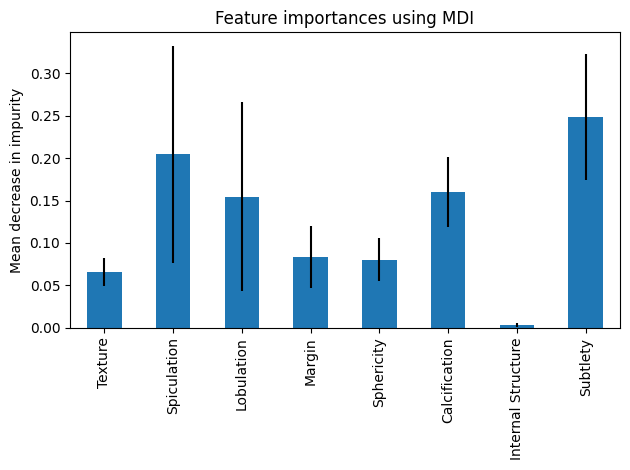

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_rf_search.best_estimator_, feature_names)

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

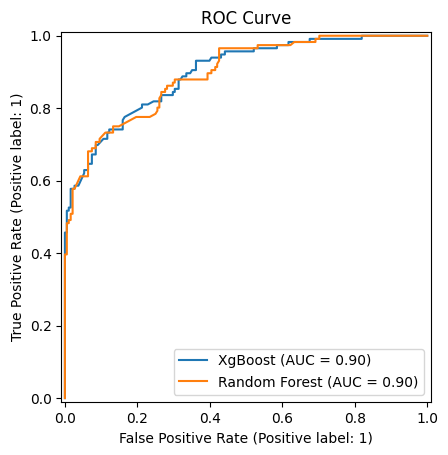

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

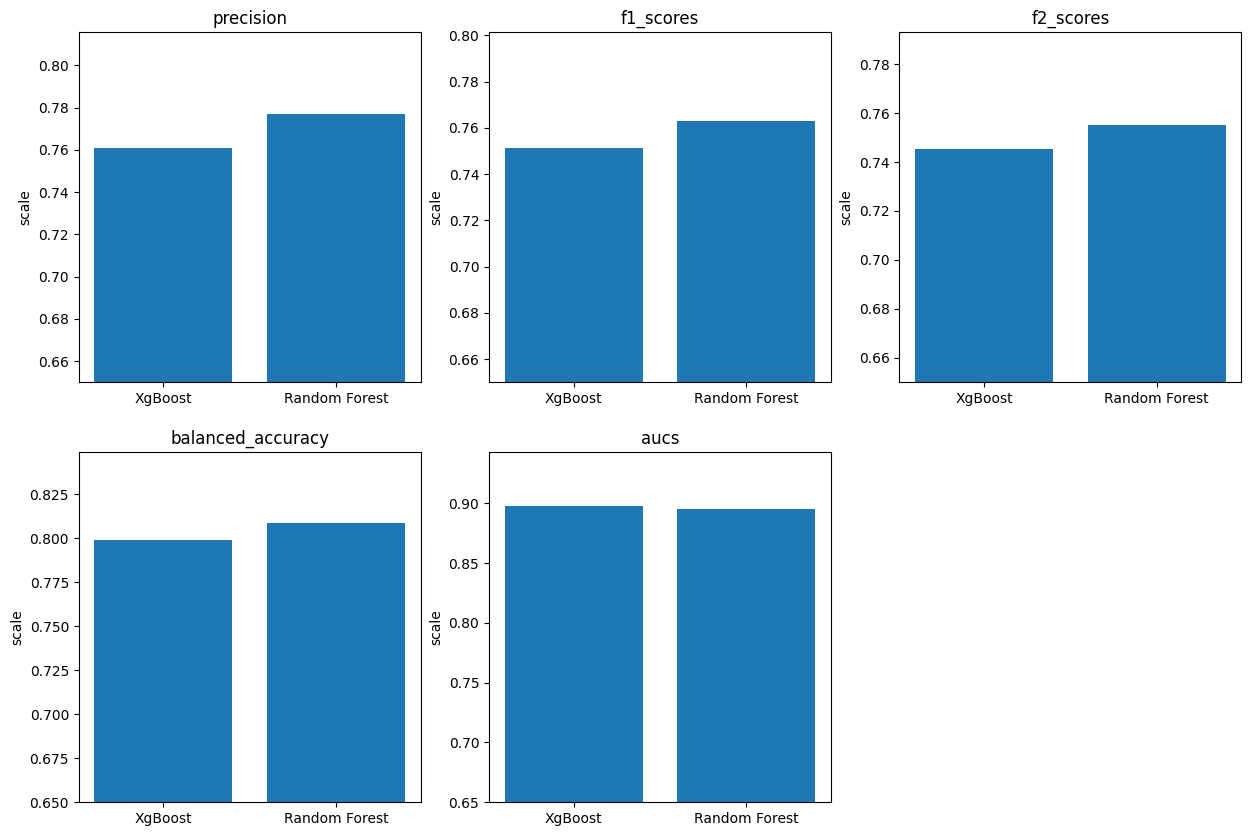

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

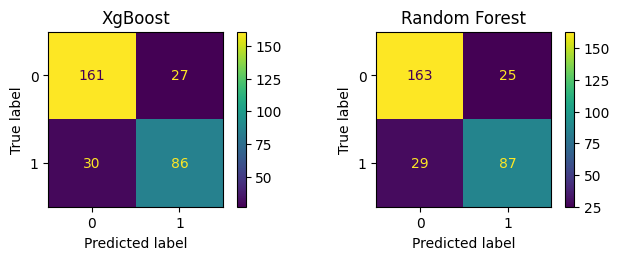

In [ ]:
models = [
    ("XgBoost", ann_xgb_search.best_estimator_),
    ("Random Forest", ann_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 2. Annotations + Radiomics

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
ann_rad_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_rad_xgb = get_scores(ann_rad_xgb_search.cv_results_, ann_rad_xgb_search.best_index_)

ann_rad_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rad_rf = get_scores(ann_rad_rf_search.cv_results_, ann_rad_rf_search.best_index_)

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_rad_rf_search.best_estimator_, feature_names)

In [ ]:
models = [
    ("XgBoost", ann_rad_xgb_search.best_estimator_),
    ("Random Forest", ann_rad_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 3. CNN 

#### 3.1. CNN Shalow Features

In [ ]:
merged_df = merge_csvs(["cnn_shallow.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_shallow_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
cnn_shallow_xgb = get_scores(cnn_shallow_xgb_search.cv_results_, cnn_shallow_xgb_search.best_index_)

cnn_shallow_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
cnn_shallow_rf = get_scores(cnn_shallow_rf_search.cv_results_, cnn_shallow_rf_search.best_index_)

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_shallow_rf_search.best_estimator_, feature_names)

In [ ]:
models = [
    ("XgBoost", cnn_shallow_xgb_search.best_estimator_),
    ("Random Forest", cnn_shallow_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

#### 3.2. CNN Deep Features

In [ ]:
merged_df = merge_csvs(["cnn_deep.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_deep_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
cnn_deep_xgb = get_scores(cnn_deep_xgb_search.cv_results_, cnn_deep_xgb_search.best_index_)

cnn_deep_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
cnn_deep_rf = get_scores(cnn_deep_rf_search.cv_results_, cnn_deep_rf_search.best_index_)

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_deep_rf_search.best_estimator_, feature_names)

In [ ]:
models = [
    ("XgBoost", cnn_deep_xgb_search.best_estimator_),
    ("Random Forest", cnn_deep_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

#### 3.3. CNN PCA pre-trained 

In [ ]:
merged_df = merge_csvs(["cnn_pca_pretrained.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_pretrained_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
cnn_pretrained_xgb = get_scores(cnn_pretrained_xgb_search.cv_results_, cnn_pretrained_xgb_search.best_index_)

cnn_pretrained_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
cnn_pretrained_rf = get_scores(cnn_pretrained_rf_search.cv_results_, cnn_pretrained_rf_search.best_index_)

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_pretrained_rf_search.best_estimator_, feature_names)

In [ ]:
models = [
    ("XgBoost", cnn_pretrained_xgb_search.best_estimator_),
    ("Random Forest", cnn_pretrained_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 4. Annotations + CNN

Because ... obtained the best results along the three dataframes, we used this one to compare with the other combinations.

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "cnn_pca_pretrained.csv"]) # TODO: change to best cnn
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_pretrained_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
cnn_pretrained_xgb = get_scores(cnn_pretrained_xgb_search.cv_results_, cnn_pretrained_xgb_search.best_index_)

cnn_pretrained_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
cnn_pretrained_rf = get_scores(cnn_pretrained_rf_search.cv_results_, cnn_pretrained_rf_search.best_index_)

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_pretrained_rf_search.best_estimator_, feature_names)

In [ ]:
models = [
    ("XgBoost", cnn_pretrained_xgb_search.best_estimator_),
    ("Random Forest", cnn_pretrained_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 5. Annotations + Radiomics + NN

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv", "cnn_shallow.csv"]) #use best nn dataframe
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
ann_rad_nn_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_rad_nn_xgb = get_scores(ann_rad_nn_xgb_search.cv_results_, ann_rad_nn_xgb_search.best_index_)

ann_rad_nn_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rad_nn_rf = get_scores(ann_rad_nn_rf_search.cv_results_, ann_rad_nn_rf_search.best_index_)

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_rad_nn_rf_search.best_estimator_, feature_names)

In [ ]:
models = [
    ("XgBoost", ann_rad_nn_xgb_search.best_estimator_),
    ("Random Forest", ann_rad_nn_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 5. Annotations + Sound

### 6. Annotations + Radiomics + Sound

### 7. Annotations + NN + Sound

### 8. Annotations + Radiomics + NN + Sound

---

## Hypothesis test

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp

In [ ]:
scores_df = pd.concat([
    ann_xgb.add_prefix("ann_xgb_"),
    ann_rf.add_prefix("ann_rf_"),
    ann_rad_xgb.add_prefix("ann-rad_xgb_"),
    ann_rad_rf.add_prefix("ann-rad_rf_"),
    cnn_shallow_xgb.add_prefix("cnn_xgb_"), # TODO: change to best cnn
    cnn_shallow_rf.add_prefix("cnn_rf_"),   # TODO: change to best cnn
    ann_rad_nn_xgb.add_prefix("ann-rad-cnn_xgb_"),
    ann_rad_nn_rf.add_prefix("ann-rad-cnn_rf_"),
    # TODO: more?
], axis=1)
scores_df.head()

,ann_xgb_recall,ann_xgb_precision,ann_xgb_f1,ann_xgb_f2,ann_xgb_balanced,ann_xgb_auc,ann_rf_recall,ann_rf_precision,ann_rf_f1,ann_rf_f2,...,ann-rad_xgb_f1,ann-rad_xgb_f2,ann-rad_xgb_balanced,ann-rad_xgb_auc,ann-rad_rf_recall,ann-rad_rf_precision,ann-rad_rf_f1,ann-rad_rf_f2,ann-rad_rf_balanced,ann-rad_rf_auc
0,0.845361,0.906077,0.874667,0.856844,0.877468,0.956515,0.876289,0.885417,0.880829,0.878099,...,0.901042,0.895445,0.900664,0.961614,0.881443,0.914439,0.897638,0.887850,0.898168,0.962464
1,0.876289,0.890052,0.883117,0.879007,0.878144,0.938792,0.891753,0.843902,0.867168,0.881753,...,0.936061,0.940391,0.931649,0.981414,0.953608,0.934343,0.943878,0.949692,0.939661,0.985979
2,0.798851,0.852761,0.824926,0.809080,0.834560,0.926887,0.821839,0.851190,0.836257,0.827546,...,0.893491,0.877907,0.898773,0.966263,0.890805,0.911765,0.901163,0.894919,0.904862,0.970767
3,0.830846,0.860825,0.845570,0.836673,0.852923,0.938168,0.855721,0.860000,0.857855,0.856574,...,0.918919,0.925743,0.921193,0.981919,0.915423,0.924623,0.920000,0.917248,0.922989,0.974572
4,0.861272,0.837079,0.849003,0.856322,0.846334,0.933929,0.890173,0.827957,0.857939,0.876993,...,0.914127,0.937500,0.910018,0.966326,0.936416,0.895028,0.915254,0.927835,0.912976,0.973148


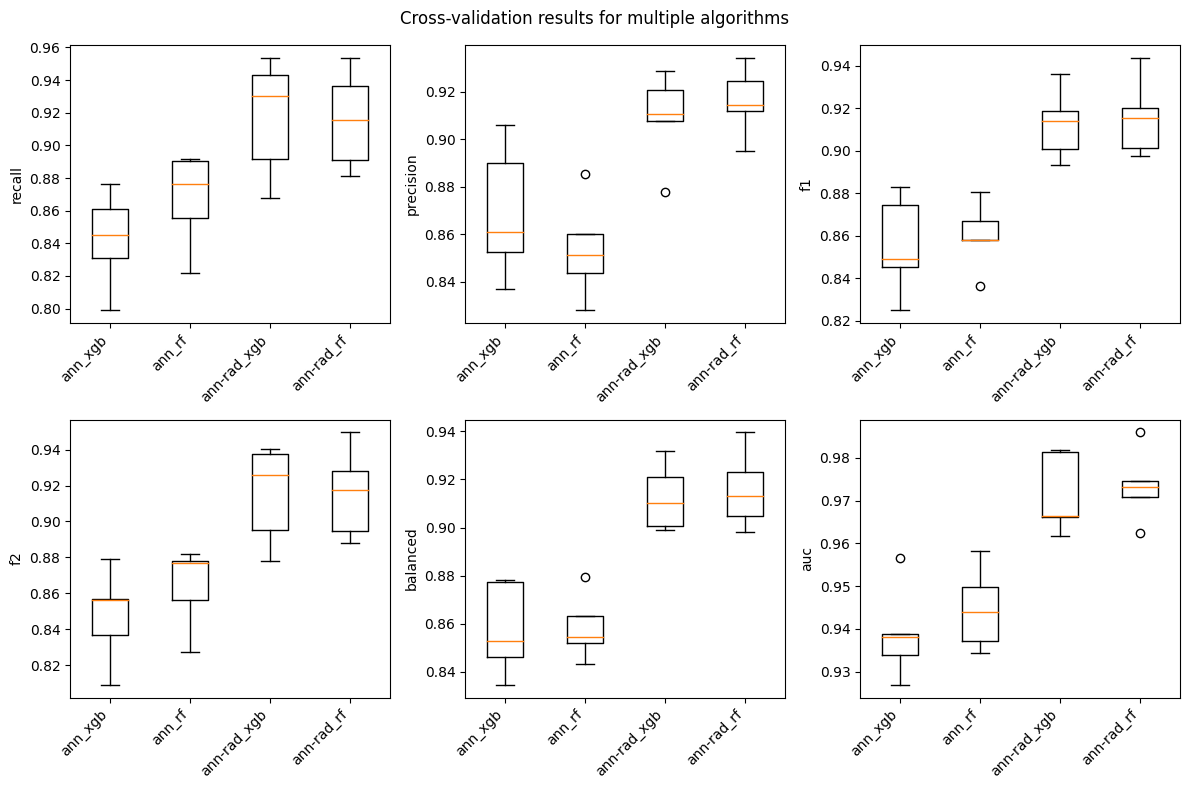

In [ ]:
def plot_cv(results_cv, metrics, title="Cross-validation results for multiple algorithms"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(len(metrics)):
        metric = metrics[i]

        ax[i//3, i%3].boxplot(results_cv.filter(regex=metric))
        ax[i//3, i%3].set_xticklabels(["_".join(c.split("_")[:2]) for c in results_cv.filter(regex=metric).columns], rotation=45, ha="right")
        ax[i//3, i%3].set_ylabel(metric.replace(".", "").replace("*", ""))

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_cv(scores_df, metrics=ann_xgb.columns.values)

In [ ]:
def friedman(results_df: pd.DataFrame, alpha=0.05):
    statistic, pvalue = stats.friedmanchisquare(*[results_df[alg] for alg in results_df.columns])
    print(f"p value: {pvalue:4f}")

    if pvalue > alpha:
        print("Probably the same distribution")
    else:
        print("Probably different distributions")

    return sp.posthoc_nemenyi_friedman(results_df)


print("Balanced Accuracy:")
paired_comp_acc = friedman(scores_df.filter(like="balanced"))
print()
print("F1 Score:")
paired_comp_f1  = friedman(scores_df.filter(like="f1"))
print()
print("Roc AUC:")
paired_comp_auc = friedman(scores_df.filter(like="auc"))

Balanced Accuracy:
p value: 0.004467
Probably different distributions

F1 Score:
p value: 0.004467
Probably different distributions

Roc AUC:
p value: 0.002851
Probably different distributions


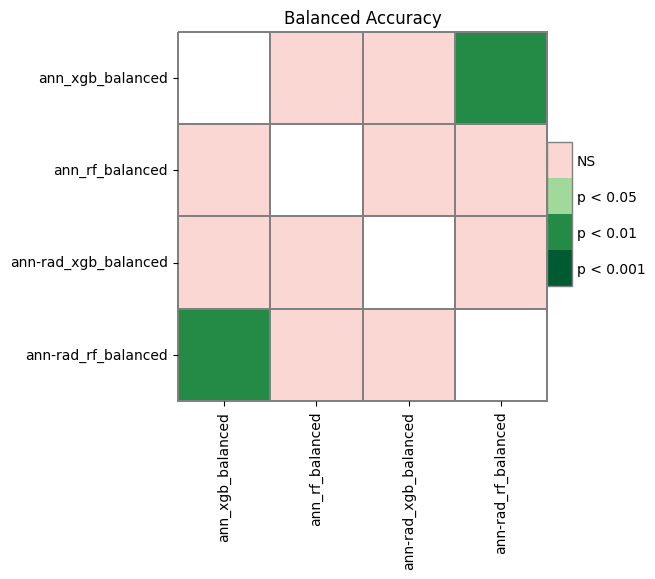

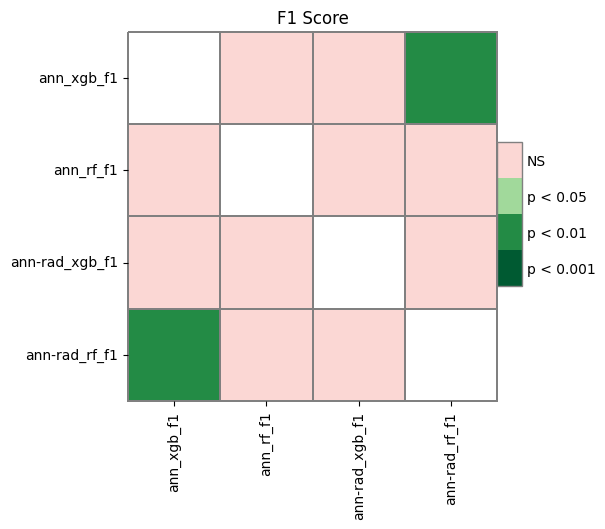

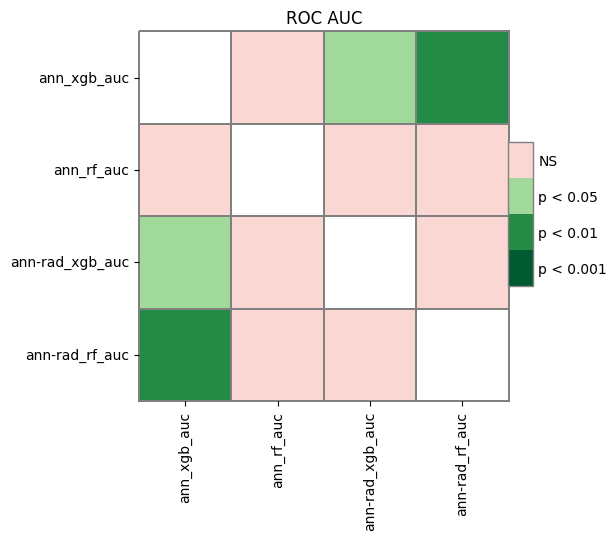

In [ ]:
def plot_multiple_comp(paired_comp, title=""):
    plt.subplot()
    plt.title(title)

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',\
    'clip_on': False, 'square': True, \
    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(paired_comp, **heatmap_args)

plot_multiple_comp(paired_comp_acc, "Balanced Accuracy")
plt.show()

plot_multiple_comp(paired_comp_f1, "F1 Score")
plt.show()

plot_multiple_comp(paired_comp_auc, "ROC AUC")
plt.show()

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


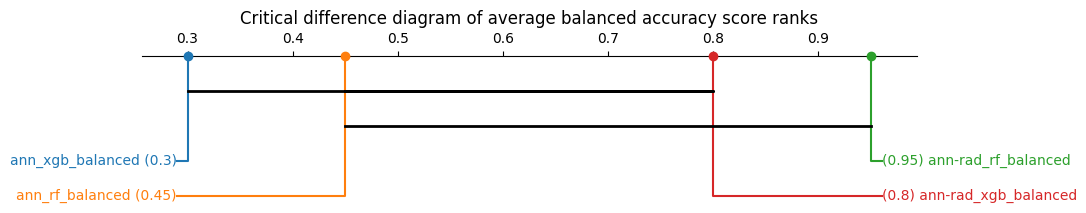

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


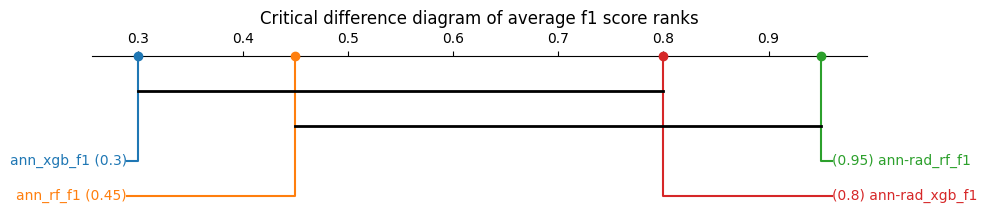

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


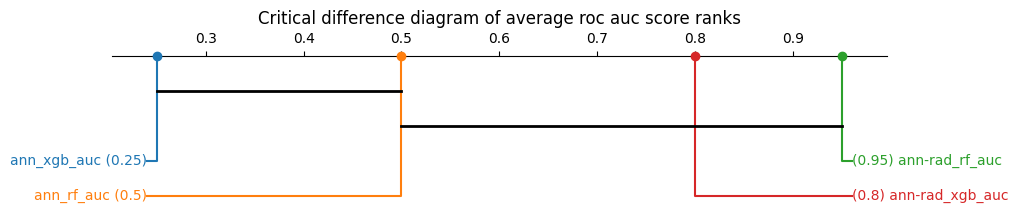

In [ ]:
def critical_difference_diagram(df: pd.DataFrame, test_results, metric="metric"):
    data = (
        df.rename_axis('cv_fold')
          .melt(
              var_name='estimator',
              value_name='score',
              ignore_index=False,
          )
          .reset_index()
    )
    avg_rank = data.groupby('cv_fold').score.rank(pct=True).groupby(data.estimator).mean()

    plt.figure(figsize=(10, 2), dpi=100)
    plt.title(f'Critical difference diagram of average {metric} score ranks')
    sp.critical_difference_diagram(avg_rank, test_results)

critical_difference_diagram(scores_df.filter(like="balanced"), paired_comp_acc, "balanced accuracy")
plt.show()

critical_difference_diagram(scores_df.filter(like="f1"), paired_comp_f1, "f1")
plt.show()

critical_difference_diagram(scores_df.filter(like="auc"), paired_comp_auc, "roc auc")
plt.show()

---

## Discussion and Conclusions

---

## References

- [1] Cellina, M., Cacioppa, L.M., Cè, M., Chiarpenello, V., Costa, M., Vincenzo, Z., Pais, D., Bausano, M.V., Rossini, N., Bruno, A. and Floridi, C. (2023). Artificial Intelligence in Lung Cancer Screening: The Future Is Now. Cancers, [online] 15(17), p.4344. doi:https://doi.org/10.3390/cancers15174344.

- [2] Lv, E., Liu, W., Wen, P. and Kang, X. (2021). Classification of Benign and Malignant Lung Nodules Based on Deep Convolutional Network Feature Extraction. Journal of Healthcare Engineering, 2021, pp.1–11. doi:https://doi.org/10.1155/2021/8769652.

- [3] Lee, G., Park, H., Bak, S.H. and Lee, H.Y. (2020). Radiomics in Lung Cancer from Basic to Advanced: Current Status and Future Directions. Korean Journal of Radiology, 21(2), p.159. doi:https://doi.org/10.3348/kjr.2019.0630.

- [4] Causey, J.L., Zhang, J., Ma, S., Jiang, B., Qualls, J.A., Politte, D.G., Prior, F., Zhang, S. and Huang, X. (2018). Highly accurate model for prediction of lung nodule malignancy with CT scans. Scientific Reports, 8(1). doi:https://doi.org/10.1038/s41598-018-27569-w.

- [5] Bhattacharjee, A., Sameh Rabea, Bhattacharjee, A., Elkaeed, E.B., R. Murugan, Refat, M., Ram Kumar Sahu, Shazly, G.A. and Salem, M. (2023). A multi-class deep learning model for early lung cancer and chronic kidney disease detection using computed tomography images. Frontiers in oncology, 13. doi:https://doi.org/10.3389/fonc.2023.1193746.

- Github.io. (2018). Scan — pylidc  documentation. [online] Available at: https://pylidc.github.io/scan.html [Accessed 15 Oct. 2024].